In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy.fft import dctn, idctn

In [2]:
class DiscreteGradientOperator(LinearOperator):
    def __init__(self, grid_shape):
        self.grid_shape = grid_shape
        self.M, self.N = self.grid_shape
        super().__init__(shape=(2*self.M*self.N, self.M*self.N), dtype=np.float64)

    def _matvec(self, x):
        
        # Reshape x to have grid shape
        x = x.reshape(self.grid_shape)
        h_diffs, v_diffs = np.zeros(self.grid_shape), np.zeros(self.grid_shape)
        h_diffs[:,:-1] = x[:,1:] - x[:,:-1]
        v_diffs[:-1,:] = x[1:,:] - x[:-1,:]
        output = np.zeros((2,self.M, self.N))
        output[0,:,:] = v_diffs
        output[1,:,:] = h_diffs
        return output.flatten()
    
    def _rmatvec(self, x):
        
        # Reshape x to have (2, M, N) shape
        x = x.reshape((2, self.M, self.N))
        p, q = x[0,:,:].copy(), x[1,:,:]

        # Pad arrays
        q = np.hstack([ np.zeros(self.M)[:,None], q])
        p = np.vstack([ np.zeros(self.N)[None,:], p])

        pdiff = p[1:,:] - p[:-1,:]
        pdiff[-1,:] = - p[-2,:]
        qdiff = q[:,1:] - q[:,:-1]
        qdiff[:,-1] = - q[:,-2]

        # Insert result
        output = -( pdiff + qdiff )

        return output

In [3]:
# Example usage:
M, N = 10, 3
operator = DiscreteGradientOperator((M, N))

In [4]:
for j in range(10):
    x = np.random.normal(size=(M,N)).flatten()
    y = np.random.normal(size=(2,M,N)).flatten()
    Rx = operator @ x
    Ry = operator.T @ y
    dot1 = (Rx*y).flatten().sum()
    dot2 = (x * Ry).flatten().sum()
    print(f"dot1 = {dot1}")
    print(f"dot2 = {dot2}")
    print(f"")

dot1 = 8.29500261144395
dot2 = 8.29500261144395

dot1 = 21.63837763080294
dot2 = 21.638377630802935

dot1 = 6.413317552403925
dot2 = 6.413317552403926

dot1 = 1.3870286072371347
dot2 = 1.387028607237133

dot1 = 11.595389033756671
dot2 = 11.595389033756668

dot1 = 0.5817829679441677
dot2 = 0.5817829679441695

dot1 = -6.467013117832501
dot2 = -6.467013117832497

dot1 = 3.4015476717468434
dot2 = 3.401547671746843

dot1 = 14.328483272992528
dot2 = 14.328483272992527

dot1 = 4.857551893686579
dot2 = 4.85755189368658



In [5]:
M, N = 10, 3
operator = DiscreteGradientOperator((M, N))
v = np.random.normal(size=(M,N)).flatten()
v = v.reshape((M,N))
p = operator @ ( idctn( v, norm="ortho" ).flatten()  )
z = operator.T @ p
z = z.reshape((M,N))
res = dctn( z, norm="ortho" ).flatten()
res = res/v.flatten()
print(res)

[2.83168121e-15 1.00000000e+00 3.00000000e+00 9.78869674e-02
 1.09788697e+00 3.09788697e+00 3.81966011e-01 1.38196601e+00
 3.38196601e+00 8.24429495e-01 1.82442950e+00 3.82442950e+00
 1.38196601e+00 2.38196601e+00 4.38196601e+00 2.00000000e+00
 3.00000000e+00 5.00000000e+00 2.61803399e+00 3.61803399e+00
 5.61803399e+00 3.17557050e+00 4.17557050e+00 6.17557050e+00
 3.61803399e+00 4.61803399e+00 6.61803399e+00 3.90211303e+00
 4.90211303e+00 6.90211303e+00]


In [6]:
def dct_diagonalized_operator_get_eigvals(A, grid_shape):
    """Given a LinearOperator A that is diagonalized by the 2-dimensional DCT, computes its eigenvalues.
    """
    M, N = grid_shape
    v = np.random.normal(size=(M,N))
    tmp = A @ ( idctn( v, norm="ortho" ).flatten()  )
    tmp = tmp.reshape((M,N))
    tmp = dctn( tmp, norm="ortho" ).flatten()
    res = tmp/v.flatten()
    return res


In [7]:
grid_shape = (M,N)
operator = DiscreteGradientOperator(grid_shape)
AtA = operator.T @ operator
eigvals = dct_diagonalized_operator_get_eigvals(AtA, grid_shape)
eigvals

array([6.01202558e-17, 1.00000000e+00, 3.00000000e+00, 9.78869674e-02,
       1.09788697e+00, 3.09788697e+00, 3.81966011e-01, 1.38196601e+00,
       3.38196601e+00, 8.24429495e-01, 1.82442950e+00, 3.82442950e+00,
       1.38196601e+00, 2.38196601e+00, 4.38196601e+00, 2.00000000e+00,
       3.00000000e+00, 5.00000000e+00, 2.61803399e+00, 3.61803399e+00,
       5.61803399e+00, 3.17557050e+00, 4.17557050e+00, 6.17557050e+00,
       3.61803399e+00, 4.61803399e+00, 6.61803399e+00, 3.90211303e+00,
       4.90211303e+00, 6.90211303e+00])

# Build Matrix square root

In [8]:
def dct_diagonalized_operator_sqrt(A, grid_shape, offset=True, offset_val=1e-2):
    """Given a LinearOperator A that is diagonalized by the DCT, performs the diagonalization (computes eigenvalues),
    computes the square root E in M = E E^T, and returns a LinearOperator representing E^{-1}.

    This can be used as a preconditioner. Instead of solving A x = b, it is equivalent to solve
        E^{-1} A E^{-T} w = E^{-1} b
    and recovering x = E^{-T} w.
    """
    # Get eigenvalues
    eigvals = dct_diagonalized_operator_get_eigvals(A, grid_shape)

    # Offset, if E is singular
    if offset:
        eigvals[0] = offset_val

    # Shape
    M, N = grid_shape

    def _matvec(x):
        x = x.reshape(grid_shape)
        tmp = dctn( x, norm="ortho" ).flatten()
        tmp = tmp/np.sqrt(eigvals)
        return tmp
    
    def _rmatvec(x):
        tmp = x/np.sqrt(eigvals)
        tmp = tmp.reshape(grid_shape)
        tmp = idctn( tmp, norm="ortho" ).flatten()
        return tmp

    Einv = LinearOperator(A.shape, matvec=_matvec, rmatvec=_rmatvec)

    return Einv

In [9]:
grid_shape = (M,N)
operator = DiscreteGradientOperator(grid_shape)
AtA = operator.T @ operator
Einv = dct_diagonalized_operator_sqrt(AtA, grid_shape)

In [10]:
output = Einv.T @ Einv @ AtA @ np.cos(np.linspace(-1,1,M*N))

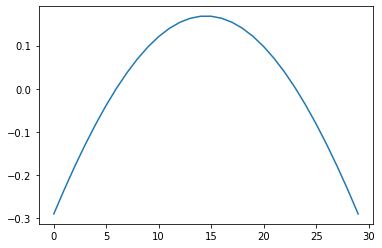

In [11]:
plt.plot(output)

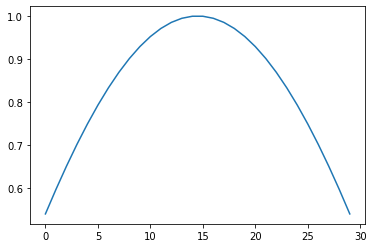

In [12]:
plt.plot(np.cos(np.linspace(-1,1,M*N)))
plt.show()

In [13]:
output = AtA @ Einv.T @ Einv @ np.cos(np.linspace(-1,1,M*N))

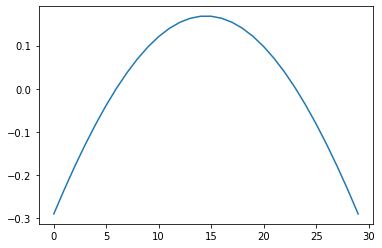

In [14]:
plt.plot(output)

# Example of preconditioned conjugate gradient?

In [27]:
from scipy.sparse.linalg import aslinearoperator
from scipy.sparse import diags
import scipy.sparse as sps

from phaseunwrapping import relative_residual_cg

In [83]:
# Set up problem
M, N = 30, 50
grid_shape = (M,N)
R = DiscreteGradientOperator(grid_shape)
weights = np.random.uniform(low=1.0, high=1.01, size=R.shape[0])
W = aslinearoperator(diags(weights))
RtWR = R.T @ (W @ R) + 1e-0*aslinearoperator(sps.eye(M*N))
# + 1e-2*aslinearoperator(sps.eye(M*N))

# Preconditioner
RtR = R.T @ R + 1e-0*aslinearoperator(sps.eye(M*N))
Einv = dct_diagonalized_operator_sqrt(RtR, grid_shape)

# RHS
np.random.seed(0)
#rhs = np.random.normal(size=M*N)
rhs = np.arange(M*N)

# Subtract off the projection onto the kernel
const_vec = np.ones(M*N)
#rhs = rhs - (  ( np.dot(const_vec, rhs)/np.dot(const_vec, const_vec) )*const_vec  ) 

n iterations without preconditioning: 21


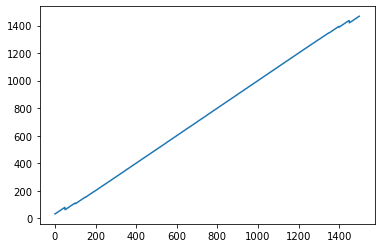

In [84]:
cg_sol = relative_residual_cg(RtWR, rhs)
sol = cg_sol["x"]
print(f"n iterations without preconditioning: {cg_sol['iterations']}")
plt.plot(sol)
plt.show()

In [87]:
# Solve precondioned system
Q = Einv @ (R.T @ R +  1e-0*aslinearoperator(sps.eye(M*N)) ) @ Einv.T
pcg_sol = relative_residual_cg(Q, Einv @ rhs)

In [89]:
print(pcg_sol["iterations"])

2


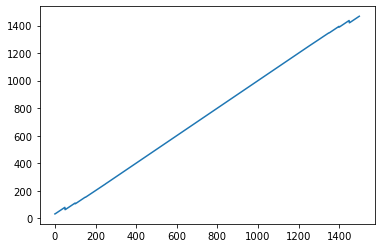

In [92]:
plt.plot(Einv.T @ pcg_sol["x"])

# Exploring when the matrix is singular?

In [106]:
# Set up problem
M, N = 30, 50
grid_shape = (M,N)
R = DiscreteGradientOperator(grid_shape)
weights = np.random.uniform(low=1.0, high=1.01, size=R.shape[0])
W = aslinearoperator(diags(weights))
RtWR = R.T @ (W @ R)
# + 1e-2*aslinearoperator(sps.eye(M*N))

# Preconditioner
RtR = R.T @ R + 1e-0*aslinearoperator(sps.eye(M*N))
Einv = dct_diagonalized_operator_sqrt(RtR, grid_shape)

# RHS
np.random.seed(0)
#rhs = np.random.normal(size=M*N)
rhs = np.arange(M*N)

# Subtract off the projection onto the kernel
const_vec = np.ones(M*N)
#rhs = rhs - (  ( np.dot(const_vec, rhs)/np.dot(const_vec, const_vec) )*const_vec  ) 

In [111]:
#rhs = R.T @ np.arange(R.T.shape[1])
rhs = rhs - (  ( np.dot(const_vec, rhs)/np.dot(const_vec, const_vec) )*const_vec  ) 

n iterations without preconditioning: 181


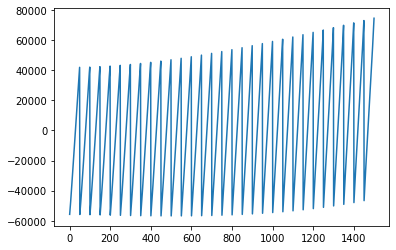

In [113]:
cg_sol = relative_residual_cg(RtWR, rhs)
sol = cg_sol["x"]
print(f"n iterations without preconditioning: {cg_sol['iterations']}")
plt.plot(sol)
plt.show()